# Wikification

This notebook cointains the code for the neural network which I had to implement as part of my project during the _Honours Programme_ at Sapienza. This task belongs to the category of _Named-entity recognition_ (NER) and the model aims to, given a sentence in natural language (written in english) as input, to recognize parts of the text into Wikipedia entities.

The whole dataset was retrieved from public [XML dumps](https://dumps.wikimedia.org/enwiki/) and then turned into useful information using a small script called __Wikifier__ which simply parses these files and extracts lines of text as well as wikilinks. The final dataset is stored as a collection of 8 files located in the directory __input_data/__. I had to split the dataset into smaller files because I was always running into memory errors but also because it provides modularity (basically you can choose the part of the dataset to use for the training).

The model was trained on a Tesla P100-PCIE-16GB x1 and was able to achieve nearly a 90% of accuracy using only 6 dumps.

## Imports

In [217]:
from argparse import Namespace
from collections import Counter
from tqdm import trange
from glob import glob
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from functools import partial
from IPython.core.display import display, HTML
from contextlib import contextmanager,redirect_stderr
import json, os, re, string, bz2, nltk, torch, wikipedia, sys
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.ticker as mtick

nltk.download('punkt')

# Comment lines below if not executing from Google Colab
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Vectorization classes

###Dataset

In [0]:
class WikiDataset(Dataset):

    test_slice = 0.10
    val_slice = 0.20
    inner_sep = '_'
    outer_sep = '|'
    link_cutoff = 50

    def __init__(self, dataset):
        
        self._dataset = dataset
        self.train_ds = self._dataset['train']
        self.val_ds = self._dataset['val']
        self.test_ds = self._dataset['test']
        self._lookup_dict = {'train': self.train_ds, 'val': self.val_ds, 'test': self.test_ds}
        self.set_split('train')

    def train_size(self):
        return len(self.train_ds['source_sentences'])

    def val_size(self):
        return len(self.val_ds['source_sentences'])

    def test_size(self):
        return len(self.test_ds['source_sentences'])

    @classmethod
    def is_a_link(cls, word):
        return len(word) >= 2 and word[0] == cls.outer_sep and word[-1] == cls.outer_sep

    @classmethod
    def pre_process(cls, text, strip_punctuation):
        #punctuation = "{[]()},.;:!?~^'\""
        
        source_sentences = [[token.lower() for token in nltk.word_tokenize(source_sentence)] for source_sentence in text.readlines()]
        valid_links = Counter(token.split(cls.outer_sep)[-2] for source_sentence in source_sentences for token in source_sentence if cls.is_a_link(token))
        valid_links = set(link for link,frequence in Counter(valid_links).items() if frequence >= cls.link_cutoff)
        sentences = []
        labels = []

        for source_sentence in source_sentences:
            sentence = []
            label = []
            has_valid_links = False
            for token in source_sentence:
                if cls.is_a_link(token):
                    _split = list(filter(None, token.split(cls.outer_sep)))
                    if len(_split) == 2:
                        text, link = _split
                        if link in valid_links:
                            link = link.replace("_", " ")
                            has_valid_links = True
                        else:
                            link = None
                        sub_links = filter(None, text.split(cls.inner_sep))
                        for sub_link in sub_links:
                            label.append(link)
                            sentence.append(sub_link)
                    else:
                        token = token.replace(cls.outer_sep, ' ').replace(cls.inner_sep, ' ')
                        label.append(None)
                        sentence.append(token)
                else:
                    label.append(None)
                    sentence.append(token)
            if has_valid_links:
                labels.append(label)
                sentences.append(sentence)
        return sentences, labels

    @classmethod
    def read_dataset(cls, ds_path, strip_punctuation):
        text = bz2.open(ds_path, mode='rt', encoding='utf-8')
        sentences, labels = cls.pre_process(text, strip_punctuation)
        train_size = int(len(sentences) * (1 - cls.test_slice - cls.val_slice))
        test_size = int(len(sentences) * cls.test_slice)
        return {
            'train': {'source_sentences': sentences[:train_size], 'target_labels' : labels[:train_size]},
            'test': {'source_sentences': sentences[train_size:train_size+test_size], 'target_labels' : labels[train_size:train_size+test_size]},
            'val': {'source_sentences' : sentences[train_size+test_size:], 'target_labels' : labels[train_size+test_size:]}
        }
    
    @classmethod
    def load_from_files(cls, ds_dir, max_files=-1, file_ext="bz2", strip_punctuation=False):
        ds_dir = ds_dir + "/" if not ds_dir.endswith("/") else ds_dir
        dumps = sorted(glob(ds_dir + "*." + file_ext))
        max_files = len(dumps) if max_files <= -1 else max_files
        ds = {
            'train': {'source_sentences': [], 'target_labels' : []},
            'test': {'source_sentences': [], 'target_labels' : []},
            'val': {'source_sentences': [], 'target_labels' : []}
        }
        for i in range(min(max(1, max_files), len(dumps))):
            path = dumps[i]
            dump = cls.read_dataset(path, strip_punctuation)
            for split in ds.keys():
                ds[split]['source_sentences'] += dump[split]['source_sentences']
                ds[split]['target_labels'] += dump[split]['target_labels']
        return cls(ds)
        

    def reduce(self, dev):
        train_mean = sum([len(x) for x in self.train_ds['source_sentences']]) / self.train_size()
        val_mean = sum([len(x) for x in self.val_ds['source_sentences']]) / self.val_size()
        test_mean = sum([len(x) for x in self.test_ds['source_sentences']]) / self.test_size()

        self.train_ds['source_sentences'] = [x for x in self.train_ds['source_sentences'] if len(x) <= train_mean*dev]
        self.train_ds['target_labels'] = [y for y in self.train_ds['target_labels'] if len(y) <= train_mean*dev]

        self.val_ds['source_sentences'] = [x for x in self.val_ds['source_sentences'] if len(x) <= val_mean*dev]
        self.val_ds['target_labels'] = [y for y in self.val_ds['target_labels'] if len(y) <= val_mean*dev]

        self.test_ds['source_sentences'] = [x for x in self.test_ds['source_sentences'] if len(x) <= test_mean*dev]
        self.test_ds['target_labels'] = [y for y in self.test_ds['target_labels'] if len(y) <= test_mean*dev]

    def encode_from(self, vocabulary):

        for i, sentence in enumerate(self.train_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.train_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.val_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.val_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.test_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.test_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.train_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.train_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.val_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.val_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.test_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.test_ds['target_labels'][i][j] = vocabulary.lookup_link(token)


    def set_split(self, split="train"):
        """ Selects the splits in the dataset, from 'train', 'val' or 'test' """
        self._target_split = split
        self._target_ds = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_ds['source_sentences'])

    def __getitem__(self, index):
        sentence = self._target_ds['source_sentences'][index]
        links = self._target_ds['target_labels'][index]
        return {'x_source': sentence, 'y_target': links, 'x_source_length' : len(sentence)}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset"""
        return len(self) // batch_size

###Vocabulary

In [0]:
class Vocabulary(object):

    _padding_token = '<PAD>'
    _unknown_token = '<UNK>'
    
    def __init__(self, word_to_index, link_to_index):
        self._word_to_index = word_to_index
        self._link_to_index = link_to_index
        self._index_to_word = {i:w for i,w in enumerate(word_to_index)}
        self._index_to_link = {i:l for i,l in enumerate(link_to_index)}

    def source_size(self):
        return len(self._word_to_index)

    def target_size(self):
        return len(self._link_to_index)
    
    def lookup_word(self, word):
        return self._word_to_index.get(word, 1)

    def lookup_link(self, link):
        return self._link_to_index[link]

    def lookup_word_index(self, index):
        return self._index_to_word.get(index, self._unknown_token)

    def lookup_link_index(self, index):
        return self._index_to_link[index]

    @classmethod
    def of(cls, ds):
        source_vocab = dict()
        target_vocab = dict()
        source_vocab = {cls._padding_token : 0, cls._unknown_token : 1}
        target_vocab = {None : 0}

        # Add words to the Vocabulary from the training set only
        for source_sequence in ds.train_ds['source_sentences']:
            for token in source_sequence:
                if token not in source_vocab:
                    source_vocab[token] = len(source_vocab)

        # Add links to the Vocabulary from train, validation and test set. In fact, 
        # this should not influence predictionsbut provides reliability to the model.
        for target_sequence in ds.train_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.val_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.test_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        return cls(source_vocab, target_vocab)

##The Model

In [0]:
class BiLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, batch_size, num_layers=1, num_directions=2, padding_idx=0, device='cpu'):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.device = device

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_directions, self.target_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device), \
        torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device))
    
    def forward(self, sequences, lengths):
        # Reset LSTM hidden state, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        # Dim transformation: (batch_size, seq_size, 1) -> (batch_size, seq_size, embedding_dim)
        embeds = self.word_embedding(sequences)
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # Please note that output_lengths are the original 'lengths'
        lstm_out, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        batch_size, seq_size, feat_size = lstm_out.shape

        # Dim transformation: (batch_size, seq_size, hidden_size * directions) -> (batch_size * seq_size, hidden_size * directions)
        lstm_out = lstm_out.contiguous().view(batch_size * seq_size, feat_size)

        # Current shape: (batch_size * seq_size, target_size)
        link_outputs = self.fc(lstm_out)
        return link_outputs

##Training Routine

###Helper functions

In [0]:
def _vectorize(indices, padding_index, vector_length):
    vector = np.zeros(vector_length, dtype=np.int)
    vector[:len(indices)] = indices
    vector[len(indices):] = padding_index
    return vector.tolist()

def vectorize(input_sequence, padding_index=0, vector_length=-1):
    if vector_length < 0:
        vector_length = input_sequence['x_source_length']

    source_sequence = _vectorize(input_sequence['x_source'], padding_index, vector_length)
    target_sequence = _vectorize(input_sequence['y_target'], padding_index, vector_length)

    return {'x_source' : source_sequence, 'y_target' : target_sequence, 'x_source_length' : input_sequence['x_source_length']}

def collate_fn(batch, device='cpu'):
    batch.sort(key=lambda sample: sample['x_source_length'], reverse=True)
    local_max_length = batch[0]['x_source_length']
    batch = [vectorize(sequence, vector_length=local_max_length) for sequence in batch]
    output_batch = {'x_source' : [], 'y_target' : [], 'x_source_length' : []}
    for sample in batch:
        output_batch['x_source'].append(sample['x_source'])
        output_batch['y_target'].append(sample['y_target'])
        output_batch['x_source_length'].append(sample['x_source_length'])
    return {'x_source' : torch.LongTensor(output_batch['x_source']).to(device), 'y_target' : torch.LongTensor(output_batch['y_target']).to(device), 'x_source_length' : torch.LongTensor(output_batch['x_source_length']).to(device)}

def compute_accuracy(y_hat, y, mask_index=0):
    y_hat = torch.argmax(y_hat, dim=1)
    y = y.view(-1)
    correct_indices = torch.eq(y_hat, y).float()
    valid_indices = torch.ne(y, mask_index).float()
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = max(1, valid_indices.sum().item())
    return n_correct / n_valid * 100

###General utilities

In [0]:
def make_state():
    return {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : [], 'test_loss' : -1, 'test_acc' : -1}

def plot_results(train_state, save_path=None):
    epochs = len(train_state['train_loss'])
    plt.rcParams["figure.figsize"] = (16,12)
    plt.style.use('fivethirtyeight')
    loss_plot = plt.subplot(211)
    loss_plot.set_xticks(np.arange(0, epochs, 1.0))
    plt.title('model loss', fontsize=14)
    plt.plot(train_state['train_loss'], label='train')
    plt.plot(train_state['val_loss'], label='validation')
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend()
    accuracy_plt = plt.subplot(212)
    accuracy_plt.yaxis.set_major_formatter(mtick.PercentFormatter())
    accuracy_plt.set_xticks(np.arange(0, epochs, 1.0))
    plt.title('model accuracy', fontsize=14)
    plt.plot(train_state['train_acc'], label='train')
    plt.plot(train_state['val_acc'], label='validation')
    plt.ylabel('accuracy', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend()
    plt.subplots_adjust(hspace=0.4)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

def save_model(model, optimizer, train_state, vocabulary, args):
    epochs = len(train_state['train_loss'])
    state = {
        'epoch': epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'vocabulary': vocabulary,
    }
    torch.save(state, os.path.join(args.save_dir + args.model_state_file))
    train_state_path = os.path.join(args.save_dir, args.train_state_file)
    plot_results(train_state, save_path=train_state_path+".jpg")
    with open(train_state_path+".json", 'w') as f_out:
        json.dump(train_state, f_out)

###Settings

In [68]:
args = Namespace(
    dataset_path="drive/My Drive/Wikifier/input_data/",
    max_files = -1,
    dev=3,
    save_dir="drive/My Drive/Wikifier/",
    model_state_file="model.pth",
    train_state_file="model_performance",
    save_model=True,
    embedding_dim = 128,
    hidden_dim = 128,
    learning_rate = 0.001,
    weight_decay = 0.0001,
    batch_size = 128,
    inference_batch_size = 1,
    shuffle = True,
    drop_last = True,
    epochs = 10,
    device="cuda"
    #early_stopping_criteria=5
)

if not torch.cuda.is_available():
    print("Running model using CPU")
    args.device = 'cpu'
else:
    print("Running model on GPU:", torch.cuda.get_device_name(0), "x" + str(torch.cuda.device_count()))

Running model on GPU: Tesla P100-PCIE-16GB x1


###Initializations

In [0]:
dataset = WikiDataset.load_from_files(args.dataset_path, max_files=args.max_files)
dataset.reduce(dev=args.dev)
vocabulary = Vocabulary.of(dataset)
dataset.encode_from(vocabulary)

model = BiLSTM(vocab_size=vocabulary.source_size(), embedding_dim=args.embedding_dim, hidden_dim=args.hidden_dim, \
               target_size=vocabulary.target_size(), batch_size=args.batch_size, device=args.device).to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=0)
train_state = make_state()

###Training loop

In [0]:
for epoch in range(args.epochs): 

    # Training

    dataset.set_split('train')
    dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for batch_index in trange(len(batch_generator), leave=True, desc="Train progress"):
        batch = batch_generator.next()

        optimizer.zero_grad()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))
        loss.backward()

        optimizer.step()

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Validation

    dataset.set_split('val')
    dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    for batch_index in trange(len(batch_generator), leave=True, desc="Validation progress"):
        batch = batch_generator.next()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

# Test

dataset.set_split('test')
dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
batch_generator = iter(dataloader)

running_loss = 0.0
running_acc = 0.0
model.eval()

for batch_index in trange(len(batch_generator), leave=True, desc="Test"):
    batch = batch_generator.next()

    x, y, x_len = batch.values()
    y_hat = model(x, x_len)

    loss = criterion(y_hat, y.view(-1))

    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_hat, y)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

Test: 100%|██████████| 2634/2634 [01:10<00:00, 37.40it/s]


###Visualize the output

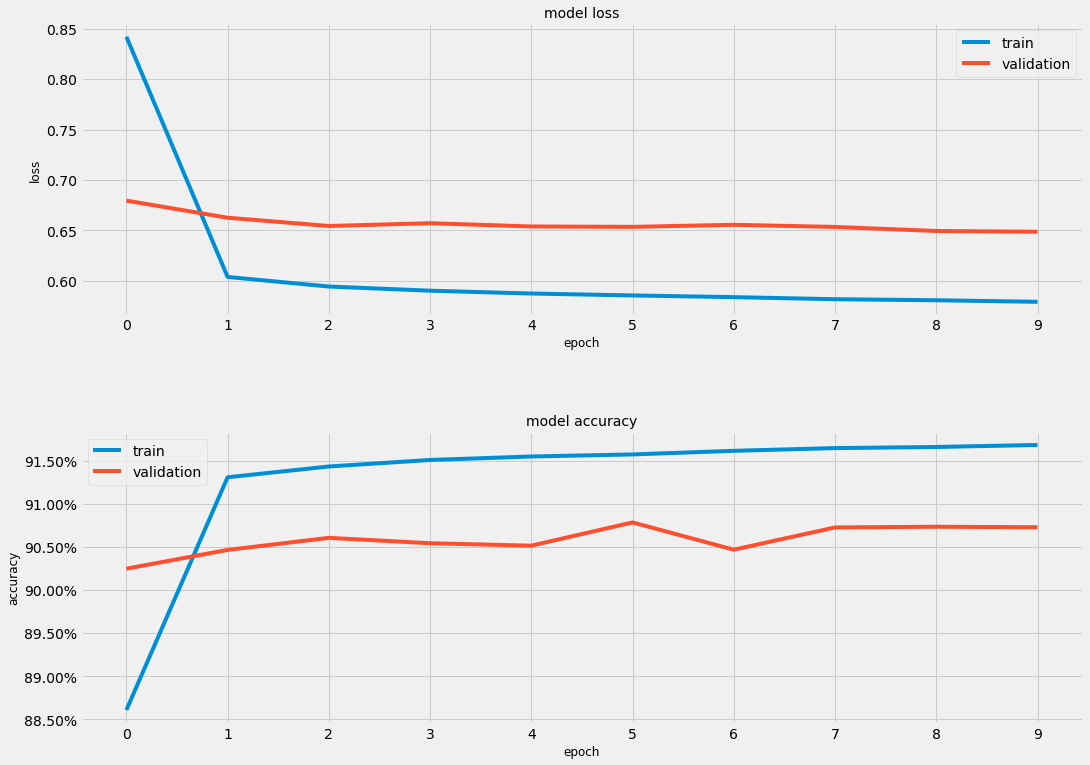

In [0]:
plot_results(train_state)
if args.save_model:
    save_model(model, optimizer, train_state, vocabulary, args)

##Inference

###Initializations

In [8]:
state = torch.load(args.save_dir + args.model_state_file)
vocabulary = state['vocabulary']
model = BiLSTM(vocab_size=vocabulary.source_size(), embedding_dim=args.embedding_dim, hidden_dim=args.hidden_dim, target_size=vocabulary.target_size(), batch_size=args.inference_batch_size, device=args.device).to(args.device)
model.load_state_dict(state['state_dict'])
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer.load_state_dict(state['optimizer'])
with open(args.save_dir + args.train_state_file + ".json") as json_data:
    train_state = json.load(json_data)
model.eval()

BiLSTM(
  (word_embedding): Embedding(986960, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7358, bias=True)
)

###Testing

In [219]:
y = 125456
#print('x  :  ',[vocabulary.lookup_word_index(k) for k in dataset[y]['x_source']])
#print('_y  : ', [vocabulary.lookup_link_index(k) for k in dataset[y]['y_target']])
#print('y  :  ', [vocabulary.lookup_link_index(k) for k in dataset[y]['y_target'] if vocabulary.lookup_link_index(k) is not None])
#indexes = [k for k in range(len(dataset[y]['y_target'])) if vocabulary.lookup_link_index(dataset[y]['y_target'][k]) != None]
#_x = "A preacher is a person who delivers sermons or homilies on religious topics to an assembly of people ."
#_x = "Fermi first major contribution involved the field of statistical mechanics."
#_x = "In physics radiation is the emission or transmission of energy in the form of waves or particles through space or through a material medium"
#_x = "The cell (from Latin cella, meaning small room) is the basic structural, functional, and biological unit of all known organisms."
#_x = "Cells consist of cytoplasm enclosed within a membrane, which contains many biomolecules such as proteins and nucleic acids."
#_x = "A set shot in Australian rules football is a kick for goal in which the player can set themselves rather than have to quickly react during the play . "
#_x = "Duns railway station was a railway station that served the town of Duns Scottish Borders , Scotland from 1849 to 1951 on the Berwickshire Railway ."
#_x = "Hart Ski Corporation is a United States based manufacturer of downhill skis originally of St Paul Minnesota and currently headquartered in Ogden Utah ."
#_x = "The big cats live in Africa"
_x = "How are you ? My name is Linus . Every , Linux system has a builtin ls function."
_x = _x.lower()
x = _x.lower()
_l = len(x.split())
x = [vocabulary.lookup_word(token) for token in x.split()]

softmax = nn.Softmax(dim=0)
#stopwords = get_stopwords(os.path.join(args.save_dir, "stopwords.txt"))
'''
'''
#x = dataset[y]['x_source']
_l = len(x)
x = torch.LongTensor([_vectorize(x, 0, _l)]).to(args.device)
l = torch.LongTensor([_l]).to(args.device)
y_hat = model(x, l)
y_hat = y_hat.view(1, _l, -1)
#print("Expected:", y_hat.shape)
#print(y_hat[0,0,:])
x1 = softmax(y_hat[0,0,:])
#x1 = F.log_softmax(y_hat[0,0,:], dim=0)
#print(torch.sum(x1, dim=0))
#print(x)
#print(x1)
#print(torch.max(x1, dim=0))
#v, ix = torch.topk(x1, 3, dim=0)
#print('asd', v.tolist(), ix)
#y_hat = torch.argmax(y_hat, dim=2)[0]
#y_hat = y_hat.tolist()
#p = [vocabulary.lookup_link_index(token) for token in y_hat]

#print('y^ :  ',[p[i] for i in indexes])
#print(vocabulary.lookup_link('artificial intelligence'))

#Display HTML link
#<sub>subscript</sub>



@contextmanager
def suppress_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err:
            yield (err)

def get_wikilink(word, link):
    #print("---:",word, link)
    
    try:
        with suppress_stderr():
            return """<a href="{}" target="_blank">{}</a>""".format(wikipedia.page(link).url, word)
    except:
        return word

def get_stopwords(path):
    with open(path, 'r') as f:
        stopwords = f.read().splitlines()
    return stopwords


def annotate(input, stopwords, args):
    softmax = nn.Softmax(dim=1)
    sentences = [nltk.word_tokenize(sentence) for sentence in nltk.sent_tokenize(input.lower())]
    lengths = torch.LongTensor([[len(sentence)] for sentence in sentences])
    input_vectors = [torch.LongTensor([[vocabulary.lookup_word(word) for word in sentence]]).to(args.device) for sentence in sentences]
    predictions = [softmax(model(sentence, length)) for i, (sentence, length) in enumerate(zip(input_vectors, lengths))]
    predictions = [[tensor.tolist() for tensor in torch.max(predictions[i], dim=1)] for i in range(len(predictions))]
    scores, predictions = list(zip(*predictions))
    predictions = [[vocabulary.lookup_link_index(token_index) for token_index in token_indices] for token_indices in predictions]

    # The line below seems to work
    #predictions = [[get_wikilink(sentences[i][j], token) if scores[i][j] > 0.18 else sentences[i][j] for j, token in enumerate(sentence)] for i, sentence in enumerate(predictions)]
    for prediction, score, sentence in zip(predictions, scores, sentences):
        s = []
        #print(prediction, end=" ")
        for i in range(len(prediction)):
            if prediction[i] not in stopwords and score[i] > 0.18:
                s.append(get_wikilink(sentence[i], prediction[i]))
            else:
                s.append(sentence[i])
        display(HTML(" ".join(s)))
        

    print()
    #print(predictions)
    #print(torch.sum(predictions[0], dim=1))

    
    #print(sentences[0], lengths[0])
    # Vectorize and turn them into Tensors ...
    #x = torch.LongTensor([_vectorize(x, 0, _l) for _ in range(args.batch_size)]).to(args.device)
    return predictions


#display(HTML("""Hi<sub><a href="https://google.com" target="_blank">link</a></sub>"""))
wikipedia.set_lang("en")
annotate(_x, stopwords, args)
#display(HTML(get_wikilink("cat", "cat")))

#print(wikipedia.page("linux").url)

#print('links:', p)
for i in range(_l):
    x1 = F.softmax(y_hat[0,i,:], dim=0)
    v, ix = torch.topk(x1, 3, dim=0)
    v, ix = v.tolist(), ix.tolist()
    link = vocabulary.lookup_link_index(ix[0]) if _x.split()[i] not in stopwords and v[0] > 0.18 else ""
    #print(_x.split()[i], v, ix, link)

##Future improvements and considerations